## Import modules

In [1]:
import numpy as np
import pandas as pd

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import preprocessing

# needs conda install m2w64-toolchain
from theano import shared
import pymc3 as pm

In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


___

## Prepare Dataset

### Load data

In [7]:
data = pd.read_csv(r'..\courses material\Bayesian Machine Learning\train_pricing.csv', parse_dates=['insert_date'])
data = data.sample(frac=0.01, random_state=99)
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
316,2019-05-08 21:13:59,MADRID,BARCELONA,2019-06-30 19:00:00,2019-06-30 21:30:00,AVE,94.55,Turista Plus,Promo
13026,2019-04-25 07:18:17,BARCELONA,MADRID,2019-05-22 06:25:00,2019-05-22 08:55:00,AVE,58.45,Turista,Promo
785,2019-04-13 17:17:51,MADRID,VALENCIA,2019-05-30 17:40:00,2019-05-30 19:20:00,AVE,57.75,Turista,Promo


### Fill-in Null Values

In [8]:
# check null values
nulls = data.isnull().sum()/len(data)
nulls[nulls > 0]

price    0.131313
dtype: float64

In [9]:
# train class: use most frequent one
data['train_class'].fillna(data['train_class'].mode(), inplace=True)

# fare: use most frequent one
data['fare'].fillna(data['fare'].mode(), inplace=True)

# price: mean for each fare
data['price'].fillna(data.groupby('fare')['price'].transform('mean'), inplace=True)

___

## Prices Distribution

The KDE plot of the rail ticket price shows a Gaussian-like distribution:


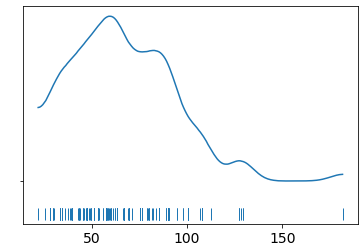

In [10]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

Let's assume that the rail ticket price follows a Gaussian distribution. We don't know mean nor standard deviation: we need to choose reasonable priors & likelihood functions.

Priors:
+ mean mu: Uniform Distribution between 0 and 300 (range of reasonable prices)
+ standard deviation sd: HalfNormal (values can only be positive) 

Likelihood:
+ Gaussian of parameters mu and sd

In [11]:

with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=0, upper=300)
    sd = pm.HalfNormal('sd', sd=10)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data['price'].values)
    trace_g = pm.sample(100, tune=100)
    

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 136.48draws/s]
The acceptance probability does not match the target. It is 0.9249415318242808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.92500703110769, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


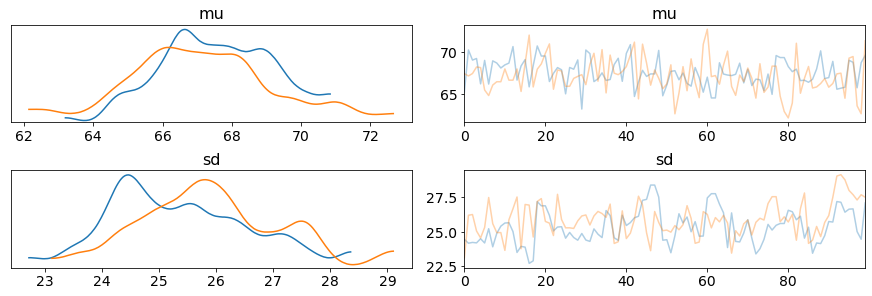

In [12]:
az.plot_trace(trace_g);

+ Our sampling chains for the individual parameters (right) seem well converged and stationary: there are no large drifts or other odd patterns.
+ The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.